In [40]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init()

import pyspark
from pyspark.sql import *
import pyspark.sql.functions as func
from pyspark.sql.types import *

In [41]:
spark = SparkSession.builder.getOrCreate()

### Loading

In [42]:
comments = spark.read.load('../data/sample.parquet')

In [43]:
comments.limit(10).toPandas().head(3)

,distinguished,retrieved_on,gilded,edited,id,parent_id,flair_text,author,score,ups,...,author_flair_context,flair_css_class,subreddit,subreddit_id,score_hidden,stickied,link_id,controversiality,body,archived
0,None,1429291671,0,-1,c595rma,t1_c595qio,None,NoNeedForAName,1,1,...,None,None,law,t5_2qh9k,False,None,t3_vysbf,0,"The fear that it's a ""grass is always greener""...",True
1,None,1429291672,0,-1,c595rqe,t3_w0bkb,None,Duderino316,2,2,...,None,None,mexico,t5_2qhv7,False,None,t3_w0bkb,0,Upvote!,True
2,None,1429291676,0,-1,c595rwc,t1_c595gbw,None,emshlaf,2,2,...,None,None,WTF,t5_2qh61,False,None,t3_vzvlq,0,"It's real, it's in New York City.",True


### Cleaning & Preparation

First, we parse the column `create_utc` into a real date.

In [44]:
comments = comments.withColumn('created', func.from_unixtime(comments['created_utc'], 'yyyy-MM-dd HH:mm:ss.SS').cast(DateType()))

In [45]:
comments = comments.limit(600000)
comments.registerTempTable("comments")

### General Information

##### Dataset

In [46]:
print("There is a total of {} comments in the dataset.".format(comments.count()))

There is a total of 600000 comments in the dataset.


In [47]:
dates_extrema = spark.sql("""
    SELECT MIN(created), MAX(created) FROM comments
""").collect()

earliest_date = dates_extrema[0][0]
latest_date = dates_extrema[0][1]

print("The dataset starts on the {} and ends on the {}.".format(earliest_date, latest_date))

The dataset starts on the 2007-12-01 and ends on the 2017-03-31.


##### Top-Level Comments

It is possible to identify top-level comments easily by using the `parent_id` attribute. If the `parent_id` attribute starts with `t1_`, then it means that the parent is another message. If the `parent_id` attribute starts with `t3_`, then its parent is a post and therefore it is a top-level comment. Another possible technique is to use `link_id` which is the id of the related post. By checking wether `parent_id == link_id`. Since equality is faster to check than using the `LIKE` operator, we will use the later technique.

In [48]:
top_level_comments = spark.sql("""
    SELECT *
    FROM comments
    WHERE parent_id=link_id
""")

In [49]:
lower_level_comments = spark.sql("""
    SELECT *
    FROM comments
    WHERE parent_id!=link_id
""")

In [50]:
print("There are {} top-level comments and {} lower level comments in this dataset.".format(
    top_level_comments.count(),
    lower_level_comments.count()
))

There are 237530 top-level comments and 362470 lower level comments in this dataset.


Now, only seeing the immediate parent of a post is not practical. We would like to view all the parents and understand the depth of a comment.

In [51]:
comments_iter = comments.withColumn('depth', func.lit(0)).withColumn('parent_ids', func.lit(''))

##### Posts

Unfortunately, the dataset only contains comments and not posts. However, we still have some information on the posts, via the `link_id` attribute of the comments.

In [52]:
posts = spark.sql("""
    SELECT 
        link_id AS id,  
        COUNT(*) AS count_of_comments, 
        FIRST(subreddit) AS subreddit,
        FIRST(subreddit_id) AS subreddit_id,
        MIN(created) AS created,
        MIN(created_utc) AS created_utc,
        COUNT(DISTINCT author) AS count_of_participants
    FROM comments
    GROUP BY link_id
    SORT BY created
""")

In [53]:
posts.registerTempTable("posts")

Now, we can compute some more sophisticated metrics. For instance, what are the top 10 posts in terms of number of comments?

In [54]:
spark.sql("""
    SELECT *
    FROM posts
    ORDER BY count_of_comments DESC
    LIMIT 10
""").show()

+---------+-----------------+-----------------+------------+----------+-----------+---------------------+
|       id|count_of_comments|        subreddit|subreddit_id|   created|created_utc|count_of_participants|
+---------+-----------------+-----------------+------------+----------+-----------+---------------------+
|t3_5bzjgp|               75|        AskReddit|    t5_2qh1i|2016-11-09| 1478677508|                   71|
|t3_42hb78|               74|              nfl|    t5_2qmg3|2016-01-24| 1453664746|                   72|
|t3_4090vf|               59|              nfl|    t5_2qmg3|2016-01-10| 1452393733|                   57|
| t3_d14xg|               58|             blog|    t5_2qh49|2010-09-02| 1283384192|                    7|
|t3_16dlvk|               56|        AskReddit|    t5_2qh1i|2013-01-11| 1357918767|                   45|
|t3_3midk5|               54|        AskReddit|    t5_2qh1i|2015-09-27| 1443315977|                   49|
|t3_5ac0p2|               52|          pokemon

##### Subreddits

In [55]:
subreddits = spark.sql("""
    SELECT 
        subreddit_id AS id,
        FIRST(subreddit) AS name,
        COUNT(*) AS count_of_comments,
        COUNT(DISTINCT link_id) AS count_of_posts, 
        MIN(created) AS created,
        MIN(created_utc) AS created_utc
    FROM comments
    GROUP BY subreddit_id
    SORT BY created
""")

In [56]:
subreddits.registerTempTable("subreddits")

In [57]:
spark.sql("""
    SELECT *
    FROM subreddits
    ORDER BY count_of_posts DESC
    LIMIT 10
""").show()

+--------+---------------+-----------------+--------------+----------+-----------+
|      id|           name|count_of_comments|count_of_posts|   created|created_utc|
+--------+---------------+-----------------+--------------+----------+-----------+
|t5_2qh1i|      AskReddit|            52837|         32364|2008-03-08| 1204960760|
|t5_2cneq|       politics|            13069|          9233|2007-12-01| 1196469669|
|t5_2qh33|          funny|            10540|          8217|2008-03-05| 1204693008|
|t5_2qh0u|           pics|            10655|          7834|2008-03-04| 1204653136|
|t5_2rfxx|leagueoflegends|             8210|          6721|2010-05-10| 1273442588|
|t5_2qh03|         gaming|             7287|          5857|2007-12-05| 1196875716|
|t5_2qh61|            WTF|             6126|          4619|2008-03-22| 1206220877|
|t5_2qh13|      worldnews|             6726|          4427|2008-03-02| 1204426632|
|t5_2qh1e|         videos|             5927|          4273|2008-05-17| 1210977907|
|t5_

##### Users



In [58]:
users = spark.sql("""
    SELECT 
        author AS username,
        COUNT(*) AS count_of_comments,
        SUM(score) AS karma,
        AVG(score) AS avg_score,
        MIN(created) AS created,
        MIN(created_utc) AS created_utc
    FROM comments
    WHERE author!='[deleted]'
    GROUP BY author
    SORT BY created
""")

In [59]:
users.registerTempTable("users")

In [60]:
spark.sql("""
    SELECT *
    FROM users
    ORDER BY karma DESC
    LIMIT 10
""").show()

+------------------+-----------------+-----+------------------+----------+-----------+
|          username|count_of_comments|karma|         avg_score|   created|created_utc|
+------------------+-----------------+-----+------------------+----------+-----------+
|    kungfumilhouse|                1|11498|           11498.0|2016-11-19| 1479572933|
|      The_Director|                7| 8088|1155.4285714285713|2011-06-28| 1309232791|
|      Blaizeranger|                2| 5719|            2859.5|2016-01-31| 1454205597|
|         rayword45|                1| 5704|            5704.0|2017-03-24| 1490391272|
| One_Peanut_Cookie|                1| 5499|            5499.0|2016-07-18| 1468810293|
|marylstreepsasleep|                2| 5284|            2642.0|2015-09-05| 1441457985|
|     Iamthewarthog|                1| 5127|            5127.0|2016-11-30| 1480533932|
|FreezerBurntCheese|                1| 5021|            5021.0|2016-04-25| 1461607416|
|        floppybeef|                5| 4950

### High-Level Metrics

##### Number of Comments per day

In [190]:
sliding_comments_per_day = spark.sql("""
    SELECT created, count_of_comments, AVG(count_of_comments) OVER (
        ORDER BY created
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS count_of_comments_60d_avg
    FROM (
        SELECT created, COUNT(*) AS count_of_comments
        FROM comments
        GROUP BY created
        ORDER BY created
    )
""")

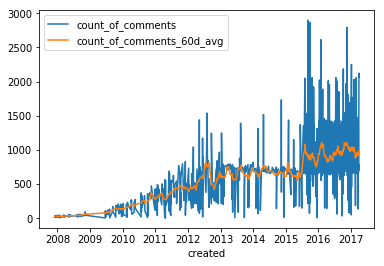

In [191]:
sliding_comments_per_day.toPandas().set_index('created').plot()

##### Number of [Removed] comments per day

In [188]:
sliding_removed_per_day = spark.sql("""
    SELECT created, count_of_removed, AVG(count_of_removed) OVER (
        ORDER BY created
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS count_of_removed_60d_avg
    FROM (
        SELECT created, COUNT(*) AS count_of_removed
        FROM comments
        WHERE body='[removed]'
        GROUP BY created
        ORDER BY created
    )
""")

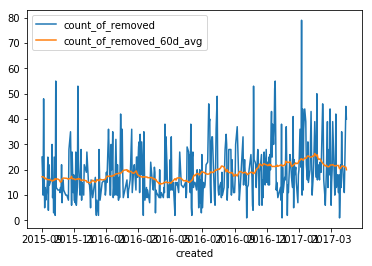

In [189]:
_ = sliding_removed_per_day.toPandas().set_index('created').rename(columns={'count(1)':'count'}).plot()

##### Number of Controversial Comments per day

In [184]:
sliding_controversial_per_day = spark.sql("""
    SELECT created, count_of_controversial, AVG(count_of_controversial) OVER (
        ORDER BY created
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS count_of_controversial_60d_avg
    FROM (
        SELECT created, COUNT(*) AS count_of_controversial
        FROM comments
        WHERE controversiality=1
        GROUP BY created
        ORDER BY created
    )
""")

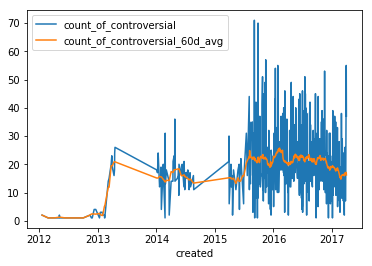

In [185]:
_ = sliding_controversial_per_day.toPandas().set_index('created').rename(columns={'count(1)':'count'}).plot()

##### Average Score per day

In [194]:
sliding_average_score_per_day = spark.sql("""
    SELECT created, avg_score, AVG(avg_score) OVER (
        ORDER BY created
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS avg_score_60d_avg
    FROM (
        SELECT created, AVG(score) AS avg_score
        FROM comments
        GROUP BY created
        ORDER BY created
    )
""")

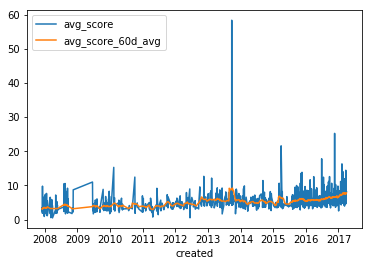

In [195]:
_ = sliding_average_score_per_day.toPandas().set_index('created').plot()

##### Total Score per Day

In [199]:
sliding_sum_score_per_day = spark.sql("""
    SELECT created, sum_score, AVG(sum_score) OVER (
        ORDER BY created
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS sum_score_60d_avg
    FROM (
        SELECT created, SUM(score) AS sum_score
        FROM comments
        GROUP BY created
        ORDER BY created
    )
""")

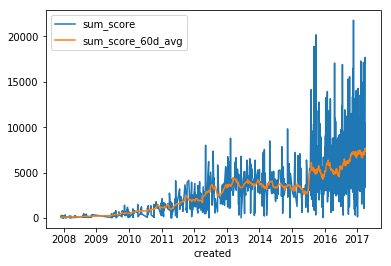

In [200]:
_ = sliding_sum_score_per_day.toPandas().set_index('created').plot()

##### Gold per day

In [73]:
gold_per_day = spark.sql("""
    SELECT created, count_gold, AVG(count_gold) OVER (
        ORDER BY created
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS count_gold_60d_avg
    FROM (
        SELECT created, SUM(gilded) AS count_gold
        FROM comments
        GROUP BY created
        ORDER BY created
    )
    SELECT created, SUM(gilded)
    FROM comments
    GROUP BY created
    ORDER BY created
""")
gold_per_day_pd = gold_per_day.toPandas().set_index('created').rename(columns={'count(1)':'count'})

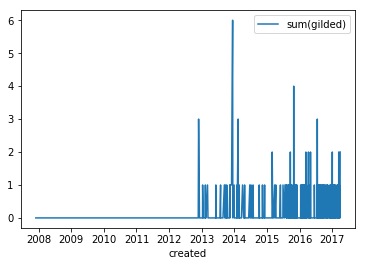

In [74]:
gold_per_day_pd.plot()